<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/9_ResNetsandHigherReceptiveFields/experiments/CIFAR10_Image_Classification_CustomResnet_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install git+https://github.com/albumentations-team/albumentations.git
!pip install torchsummary
!pip install torch-lr-finder
!pip install hiddenlayer

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-cpmboeqv
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-cpmboeqv
  Created wheel for albumentations: filename=albumentations-1.0.1-cp37-none-any.whl size=98544 sha256=f181edd18eee93ffa184bb944a0512742953c83e6a6d5f8ed0dfe0214a257d0c
  Stored in directory: /tmp/pip-ephem-wheel-cache-sd2suekk/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations


In [ ]:
!git clone https://github.com/gkdivya/torch_cv_wrapper.git /content/drive/MyDrive/Cifar10_Resnet/session9/torch_cv_wrapper

In [ ]:
%cd "/content/drive/MyDrive/Cifar10_Resnet/session9/"
from __future__ import print_function
import torchvision
import torch
from pprint import pprint
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

## Import Custom Libraries
from torch_cv_wrapper.utils import plot_metrics,train,test,helper
from torch_cv_wrapper.utils.gradcam import generate_gradcam, plot_gradcam
from torch_cv_wrapper.model import customresnet
from torch_cv_wrapper.main import TriggerEngine

/content/drive/MyDrive/Cifar10_Resnet/session9


## Load config file

In [ ]:
config = helper.process_config("/content/drive/MyDrive/Cifar10_Resnet/session9/session9.yaml")
use_cuda = torch.cuda.is_available()
helper.set_seed(config['model_params']['seed'],use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
pprint(config)

 loading Configuration of your experiment ..
{'criterion': 'CrossEntropyLoss',
 'data_augmentation': {'type': 'CIFAR10AlbumentationS9'},
 'data_loader': {'args': {'batch_size': 512,
                          'num_workers': 2,
                          'pin_memory': True},
                 'classes': ['plane',
                             'car',
                             'bird',
                             'cat',
                             'deer',
                             'dog',
                             'frog',
                             'horse',
                             'ship',
                             'truck'],
                 'type': 'Cifar10DataLoader'},
 'lr_finder': {'lr_epochs': 25, 'max_epoch': 5},
 'lr_scheduler': 'OneCycleLR',
 'model': 'CustomResnet',
 'model_params': {'dropout': 0.05,
                  'experiment_name': 'cifar10_with_customresnet',
                  'model_dir': './model/',
                  'seed': 1},
 'optimizer': {'args': {'lr':

## Create Training Instance

In [ ]:
exp_metrics={}
experiment_name=config['model_params']['experiment_name']
trigger_training=TriggerEngine(config)

## Download data and view sample images

In [ ]:
classes= config['data_loader']['classes']

#Get dataloaders
train_loader,test_loader = trigger_training.dataloader()

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


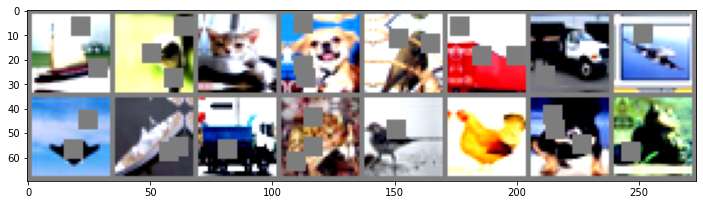

In [ ]:
# get some random training images
images, labels = iter(train_loader).next()

# # show images
helper.imshow(torchvision.utils.make_grid(images[:16]))

## Model Summary

In [ ]:
model = customresnet.CustomResNet()
model.to(device)
trigger_training.model_summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
       BasicBlock-14          [-1, 128,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Visualize Network Architecture

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


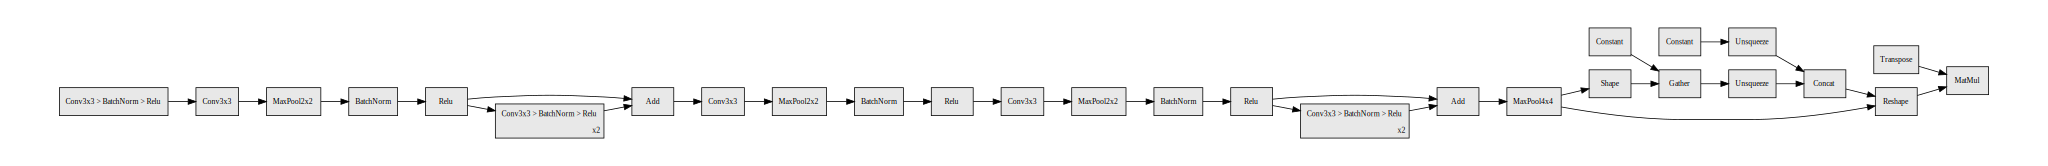

In [ ]:
import hiddenlayer as hl
input = torch.zeros([1, 3, 32, 32])
hl.build_graph(model, input.to(device))

## Find Best LR


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.54E-02


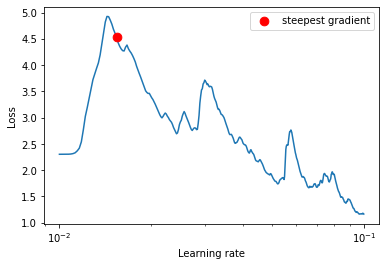

In [ ]:
start_lr = 1e-2
end_lr = 0.1
lrmax= trigger_training.find_lr(model,train_loader, test_loader, start_lr, end_lr)

## Trigger training

In [ ]:
# trigger_training.
(exp_metrics[experiment_name]) = trigger_training.run_experiment(model,train_loader,test_loader,start_lr,lrmax)

  0%|          | 0/98 [00:00<?, ?it/s]

using OneCycleLR
Epoch 1:


Loss=1.393445611000061 Batch_id=97 LR=0.01277 Accuracy=41.78: 100%|██████████| 98/98 [00:14<00:00,  6.60it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 4880/10000 (48.80%)

Epoch 2:


Loss=1.5896824598312378 Batch_id=97 LR=0.03607 Accuracy=52.86: 100%|██████████| 98/98 [00:14<00:00,  6.60it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 3935/10000 (39.35%)

Epoch 3:


Loss=0.9837324023246765 Batch_id=97 LR=0.06483 Accuracy=60.64: 100%|██████████| 98/98 [00:14<00:00,  6.59it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 6618/10000 (66.18%)

Epoch 4:


Loss=1.0408490896224976 Batch_id=97 LR=0.08802 Accuracy=68.03: 100%|██████████| 98/98 [00:14<00:00,  6.58it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 7174/10000 (71.74%)

Epoch 5:


Loss=0.69330894947052 Batch_id=97 LR=0.09675 Accuracy=74.09: 100%|██████████| 98/98 [00:14<00:00,  6.60it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7481/10000 (74.81%)

Epoch 6:


Loss=0.49709442257881165 Batch_id=97 LR=0.09608 Accuracy=78.17: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8118/10000 (81.18%)

Epoch 7:


Loss=0.7291052937507629 Batch_id=97 LR=0.09411 Accuracy=80.66: 100%|██████████| 98/98 [00:14<00:00,  6.59it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8230/10000 (82.30%)

Epoch 8:


Loss=0.5255696177482605 Batch_id=97 LR=0.09088 Accuracy=82.47: 100%|██████████| 98/98 [00:14<00:00,  6.57it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8389/10000 (83.89%)

Epoch 9:


Loss=0.3733047544956207 Batch_id=97 LR=0.08650 Accuracy=84.02: 100%|██████████| 98/98 [00:14<00:00,  6.54it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8497/10000 (84.97%)

Epoch 10:


Loss=0.40863776206970215 Batch_id=97 LR=0.08108 Accuracy=85.30: 100%|██████████| 98/98 [00:14<00:00,  6.54it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8609/10000 (86.09%)

Epoch 11:


Loss=0.3172837793827057 Batch_id=97 LR=0.07477 Accuracy=86.47: 100%|██████████| 98/98 [00:14<00:00,  6.59it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8522/10000 (85.22%)

Epoch 12:


Loss=0.3396202623844147 Batch_id=97 LR=0.06773 Accuracy=87.45: 100%|██████████| 98/98 [00:14<00:00,  6.58it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8578/10000 (85.78%)

Epoch 13:


Loss=0.3128763735294342 Batch_id=97 LR=0.06017 Accuracy=88.47: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8676/10000 (86.76%)

Epoch 14:


Loss=0.2801516354084015 Batch_id=97 LR=0.05229 Accuracy=89.15: 100%|██████████| 98/98 [00:14<00:00,  6.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8866/10000 (88.66%)

Epoch 15:


Loss=0.3086865544319153 Batch_id=97 LR=0.04430 Accuracy=90.68: 100%|██████████| 98/98 [00:14<00:00,  6.55it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8953/10000 (89.53%)

Epoch 16:


Loss=0.22756949067115784 Batch_id=97 LR=0.03642 Accuracy=91.36: 100%|██████████| 98/98 [00:14<00:00,  6.60it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8886/10000 (88.86%)

Epoch 17:


Loss=0.1748257428407669 Batch_id=97 LR=0.02887 Accuracy=92.22: 100%|██████████| 98/98 [00:14<00:00,  6.61it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8981/10000 (89.81%)

Epoch 18:


Loss=0.13607347011566162 Batch_id=97 LR=0.02185 Accuracy=92.87: 100%|██████████| 98/98 [00:14<00:00,  6.57it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8981/10000 (89.81%)

Epoch 19:


Loss=0.18030963838100433 Batch_id=97 LR=0.01555 Accuracy=93.70: 100%|██████████| 98/98 [00:14<00:00,  6.59it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9108/10000 (91.08%)

Epoch 20:


Loss=0.1585162878036499 Batch_id=97 LR=0.01015 Accuracy=94.75: 100%|██████████| 98/98 [00:14<00:00,  6.61it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9178/10000 (91.78%)

Epoch 21:


Loss=0.13056257367134094 Batch_id=97 LR=0.00579 Accuracy=95.45: 100%|██████████| 98/98 [00:14<00:00,  6.65it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9132/10000 (91.32%)

Epoch 22:


Loss=0.11024980247020721 Batch_id=97 LR=0.00260 Accuracy=96.09: 100%|██████████| 98/98 [00:14<00:00,  6.56it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9204/10000 (92.04%)

Epoch 23:


Loss=0.10663355141878128 Batch_id=97 LR=0.00065 Accuracy=96.49: 100%|██████████| 98/98 [00:14<00:00,  6.60it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9224/10000 (92.24%)

Epoch 24:


Loss=0.10737984627485275 Batch_id=97 LR=0.00000 Accuracy=96.67: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]



Test set: Average loss: 0.0005, Accuracy: 9235/10000 (92.35%)



## Missclassification

Total wrong predictions are 765
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


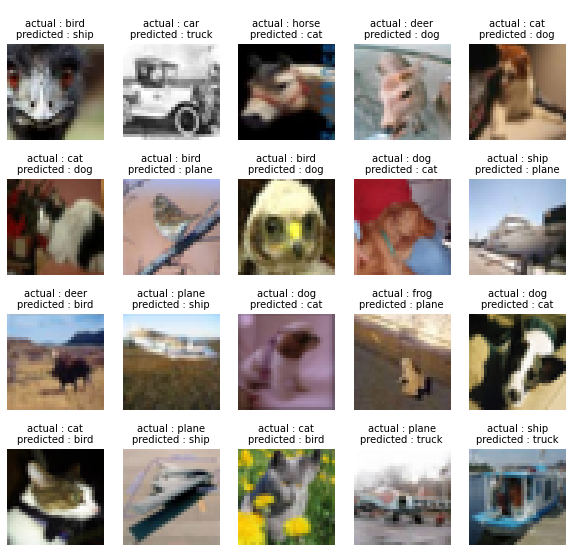

In [ ]:
misclassified_images = trigger_training.wrong_predictions(model,test_loader)

## Plots for Validation Loss and Accuracy

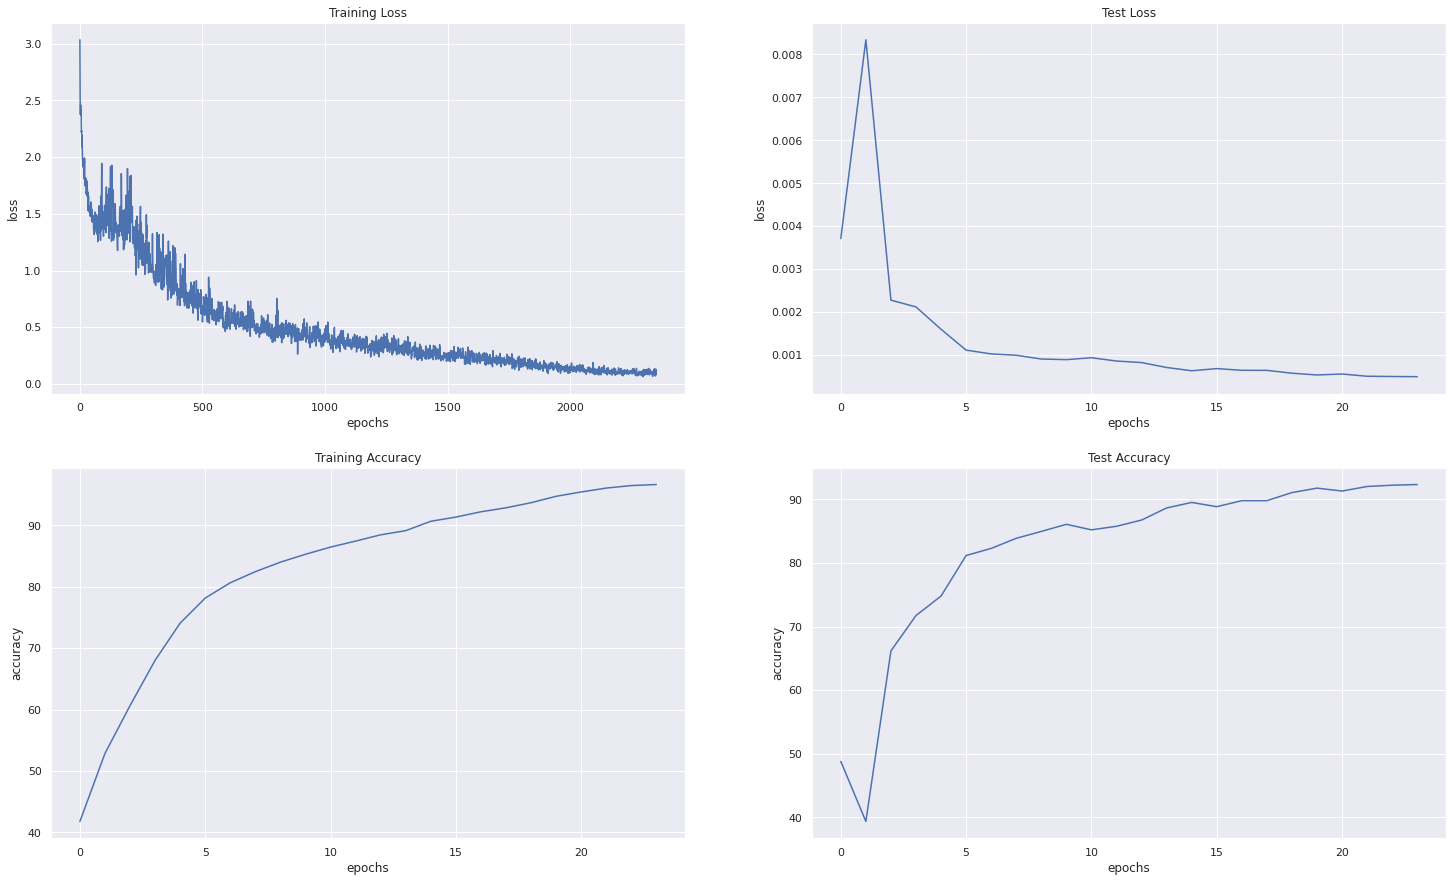

In [ ]:
plot_metrics.plot_metrics(exp_metrics[experiment_name])

## Accuracy for each class

In [ ]:
helper.class_level_accuracy(model, test_loader, device, classes)

Accuracy of plane : 94 %
Accuracy of   car : 97 %
Accuracy of  bird : 89 %
Accuracy of   cat : 82 %
Accuracy of  deer : 93 %
Accuracy of   dog : 87 %
Accuracy of  frog : 95 %
Accuracy of horse : 94 %
Accuracy of  ship : 95 %
Accuracy of truck : 95 %


## Plot Confusion Matrix

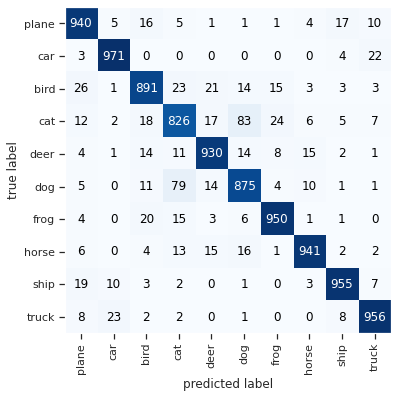

In [ ]:
mat = helper.compute_confusion_matrix(model,test_loader,device)
plot_metrics.plot_confusion_matrix(mat, class_names=classes)


## Generate & Plot GradCam Images

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3


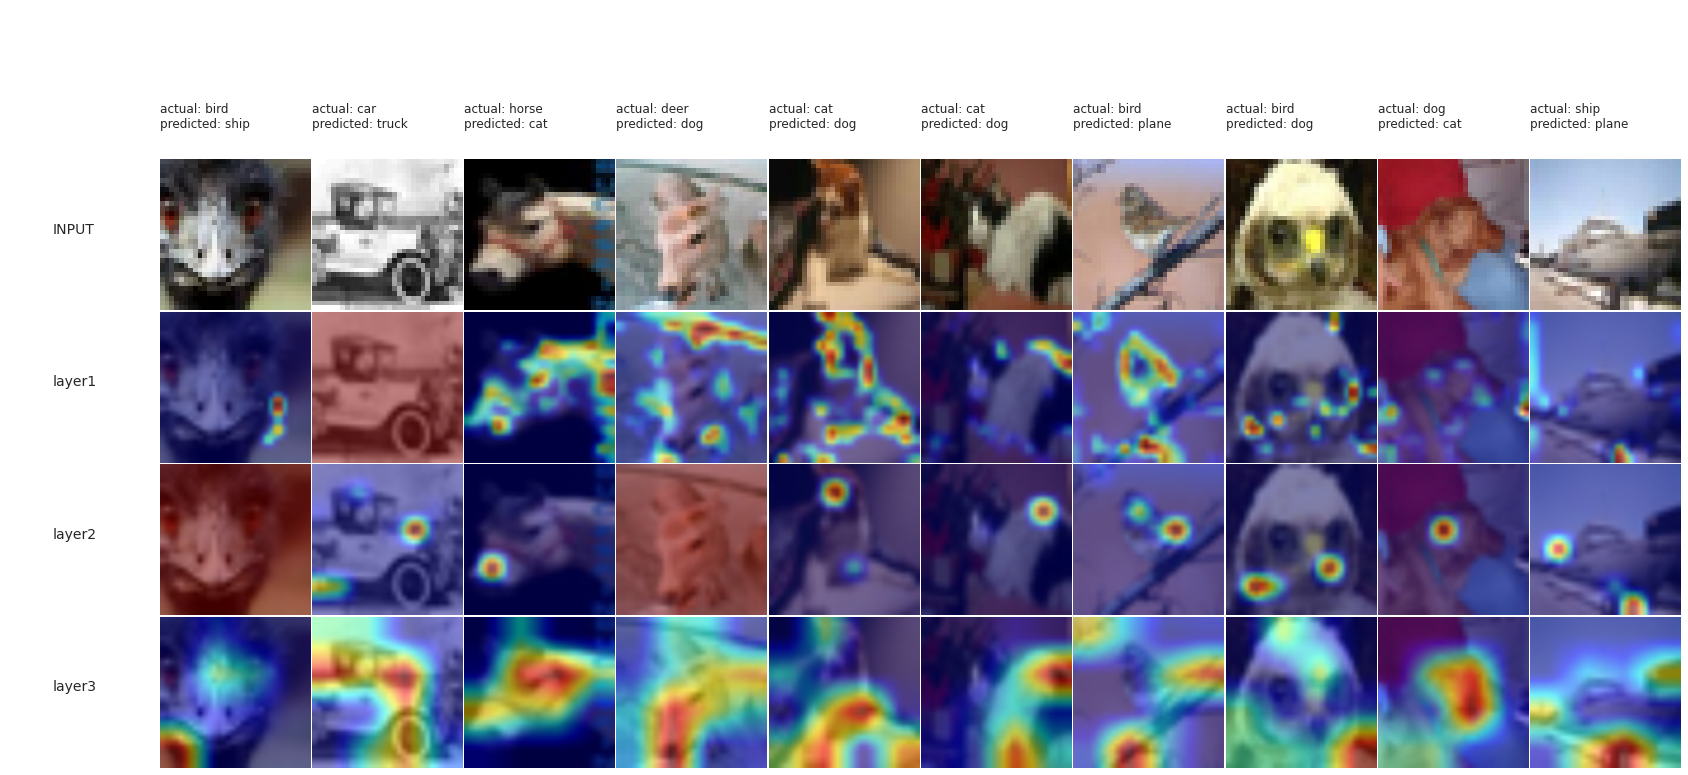

In [ ]:
target_layers = ["layer1","layer2","layer3"]
gradcam_output, probs, predicted_classes = generate_gradcam(misclassified_images[:10], model, target_layers,device)
plot_gradcam(gradcam_output, target_layers, classes, (3, 32, 32),predicted_classes, misclassified_images[:10])

In [ ]:

# %load_ext tensorboard
# %tensorboard --logdir=runs